# Speech Emotion Recognition - Time Distributed ConvNet

A project for the French Employment Agency

Telecom ParisTech 2018-2019

## I. Context
In this project I build a prevision model using deep learning combining **CNN**  and  **LSTM**  to detect a person’s emotions (HAPPY, SAD, FEAR, ANGRY, DISGUST, SURPRISE, NEUTRAL) just by their voice. 

### Audio features:
- **Log-mel-spectrogram**: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency


### Data:
- **RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## II. General Imports

In [2]:
### General imports ###
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

## III. Import datas

In [3]:
# RAVDESS mel-Spectrogram
X_train = pickle.load(open('C:/Users/sanka/OneDrive/Desktop/EMOTION RECOGNITION SIMULATOR/Audio-Model/Data/Pickle/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('C:/Users/sanka/OneDrive/Desktop/EMOTION RECOGNITION SIMULATOR/Audio-Model/Data/Pickle/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('C:/Users/sanka/OneDrive/Desktop/EMOTION RECOGNITION SIMULATOR/Audio-Model/Data/Pickle/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('C:/Users/sanka/OneDrive/Desktop/EMOTION RECOGNITION SIMULATOR/Audio-Model/Data/Pickle/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

## IV. Encode label

In [4]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

## V. Reshape train and test set

In [5]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

## VI. Time Distributed ConvNet model

In [14]:
K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

In [15]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('C:/Users/sanka/OneDrive/Desktop/EMOTION RECOGNITION SIMULATOR/Audio-Model/Audio model/[CNN-LSTM]Model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=110, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/110
51/51 [==============================] - 650s 12s/step - loss: 1.9581 - accuracy: 0.1634 - val_loss: 2.2307 - val_accuracy: 0.1375
Epoch 2/110
51/51 [==============================] - 610s 12s/step - loss: 1.8681 - accuracy: 0.2307 - val_loss: 1.9914 - val_accuracy: 0.1450
Epoch 3/110
51/51 [==============================] - 607s 12s/step - loss: 1.7654 - accuracy: 0.2949 - val_loss: 1.7366 - val_accuracy: 0.2788
Epoch 4/110
51/51 [==============================] - 648s 13s/step - loss: 1.7082 - accuracy: 0.3057 - val_loss: 1.8135 - val_accuracy: 0.3011
Epoch 5/110
51/51 [==============================] - 613s 12s/step - loss: 1.6571 - accuracy: 0.3250 - val_loss: 2.0450 - val_accuracy: 0.2491
Epoch 6/110
51/51 [==============================] - 594s 12s/step - loss: 1.6195 - accuracy: 0.3504 - val_loss: 1.8953 - val_accuracy: 0.3011
Epoch 7/110
51/51 [==============================] - 575s 11s/step - loss: 1.5835 - accuracy: 0.3513 - val_loss: 1.9395 - val_accuracy: 0.3086

 5/51 [=>............................] - ETA: 10:58 - loss: 1.1023 - accuracy: 0.5688

KeyboardInterrupt: 

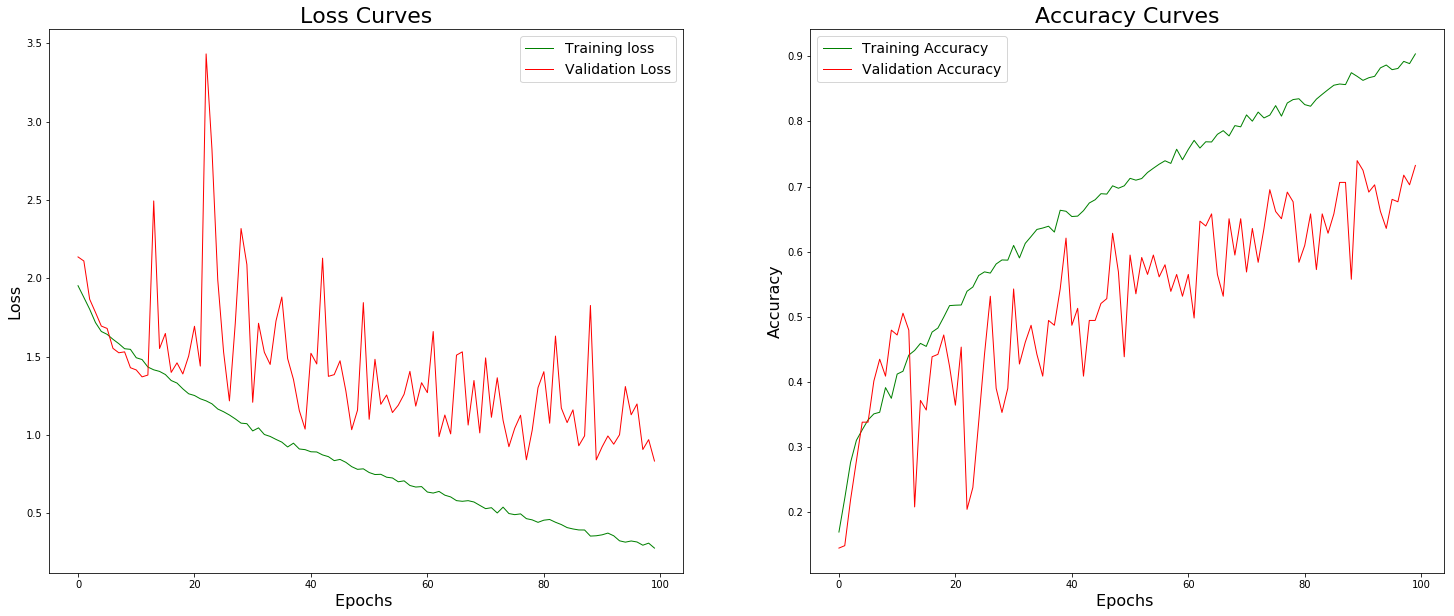

In [8]:
# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)
 
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'],'-g',linewidth=1.0)
plt.plot(history.history['val_acc'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

## VII. Save model

In [0]:
model.save('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]W.h5')